# Zonal Jet QG Feature Example #

Here is a quick overview of how to use the zonal jet feature. The zonal jet
feature is available in all PyQG models, but in this example we use the QG Model.
See the :py:class:``pyqg.QGModel`` api documentation for further details.

First import numpy, matplotlib, and pyqg:

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pyqg

## Initialize and Run the Model ##

We define initial conditions where the upper layer currents are zonally uniform
and have a Gaussian jet centered on the domain, with the flow in the lower layer
being of half the magnitude as in the upper.

In [2]:
a = 0.25
c=20.
nx = 256.
b=nx/2.
U1 = 0.0 + a * np.exp(-((np.arange(nx,dtype=float)-b)**2)/(2*c**2))
U2 = U1 / 2.0

We then set up a model which will run for 10 years and start averaging
after 5 years. The model is also seeded with random perturbations to its
potential vorticity to generate a reasonably uniform distribution of eddies.

In [3]:
year = 24*60*60*360.
m = pyqg.QGModel(tavestart=5*year,  dt=500, tmax=10*year, U1=U1,U2=U2, nx=nx)
fk = m.wv != 0
ckappa = np.zeros_like(m.wv2)
ckappa[fk] = np.sqrt( m.wv2[fk]*(1. + (m.wv2[fk]/36.)**2) )**-1
nhx,nhy = m.wv2.shape
Pi_hat = np.random.randn(nhx,nhy)*ckappa +1j*np.random.randn(nhx,nhy)*ckappa
Pi = m.ifft( Pi_hat[np.newaxis] )
Pi = Pi - Pi.mean()
Pi_hat = m.fft( Pi )
KEaux = spec_var( m, m.filtr*m.wv*Pi_hat )
pih = ( Pi_hat/np.sqrt(KEaux[:,np.newaxis,np.newaxis]) )
qih = -m.wv2*pih
qi = m.ifft(qih)
m.set_q(qi)
m.run()

## Visualize Output ##

We access the actual pv values through the attribute ``m.q``. The first
axis of ``q`` corresponds with the layer number. (Remeber that in
python, numbering starts at 0.). We then add the calculated PV of the background
current to the planetary PV.

In [4]:
Q1 = np.expand_dims(m.Qy1 - np.gradient(np.gradient(m.U1, m.dy), m.dy), axis=1) * m.y + np.gradient(m.U1, m.dy)
clevels = np.arange(-0.0005, 0.00075, 0.000025)
levels = np.arange(-0.0005,0.0008,0.0001)
f = plt.contourf(Q1 + m.q[0,:],levels=clevels, extend='both')
plt.contour(Q1 + m.q[0,:],levels=levels, extend='both', colors='#444444')
plt.clim([-0.0005,0.00075])
plt.colorbar(f)


## Plot Diagnostics ##

The model automatically accumulates averages of certain diagnostics. We can 
find out what diagnostics are available by calling

In [5]:
m.describe_diagnostics()

NAME       | DESCRIPTION
--------------------------------------------------------------------------------
APEflux    | spectral flux of available potential energy           
APEgen     | total APE generation                                  
APEgenspec | spectrum of APE generation                            
EKE        | mean eddy kinetic energy                              
EKEdiss    | total energy dissipation by bottom drag               
Ensspec    | enstrophy spectrum                                    
KEflux     | spectral flux of kinetic energy                       
KEspec     |  kinetic energy spectrum                              
entspec    | barotropic enstrophy spectrum                         
q          | QGPV                                                  


To look at the wavenumber energy spectrum, we plot the `KEspec` diagnostic.
(Note that summing along the l-axis, as in this example, does not give us
a true *isotropic* wavenumber spectrum.)

In [6]:
kespec_u = m.get_diagnostic('KEspec')[0].sum(axis=0)
kespec_l = m.get_diagnostic('KEspec')[1].sum(axis=0)
plt.loglog( m.kk, kespec_u, '.-' )
plt.loglog( m.kk, kespec_l, '.-' )
plt.legend(['upper layer','lower layer'], loc='lower left')
plt.ylim([1e-9,1e-3]); plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Kinetic Energy Spectrum');

We can also plot the spectral fluxes of energy.

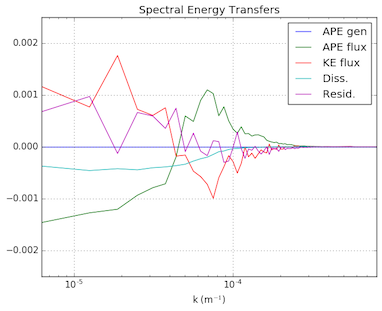

In [7]:
ebud = [ m.get_diagnostic('APEgenspec').sum(axis=0),
         m.get_diagnostic('APEflux').sum(axis=0),
         m.get_diagnostic('KEflux').sum(axis=0),
         -m.rek*m.del2*m.get_diagnostic('KEspec')[1].sum(axis=0)*m.M**2 ]
ebud.append(-np.vstack(ebud).sum(axis=0))
ebud_labels = ['APE gen','APE flux','KE flux','Diss.','Resid.']
[plt.semilogx(m.kk, term) for term in ebud]
plt.legend(ebud_labels, loc='upper right')
plt.xlim([m.kk.min(), m.kk.max()])
plt.xlabel(r'k (m$^{-1}$)'); plt.grid()
plt.title('Spectral Energy Transfers');